In [1]:
%load_ext lab_black
%load_ext autoreload
%autoreload 2

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from utils import multi_group_plot_wrapper, lighten_boxplot
import pandas as pd
import numpy as np
import pickle
import statsmodels.api as sm
import calpgs

np.random.seed(42)
plt.rcParams["font.family"] = "Arial"

# Constant slope main results

In [2]:
def fix_xaxis(axes):
    # overall
    axes[0].set_xticks([])
    # PC1
    axes[1].set_xlabel("PC1 quintile")
    axes[1].set_xticklabels(np.arange(1, 6))
    # age quintile
    axes[2].set_xlabel("Age quintile")
    axes[2].set_xticklabels(np.arange(1, 6))
    # sex
    axes[3].set_xlabel("Sex")
    axes[3].set_xticklabels(["Female", "Male"], fontsize=8)

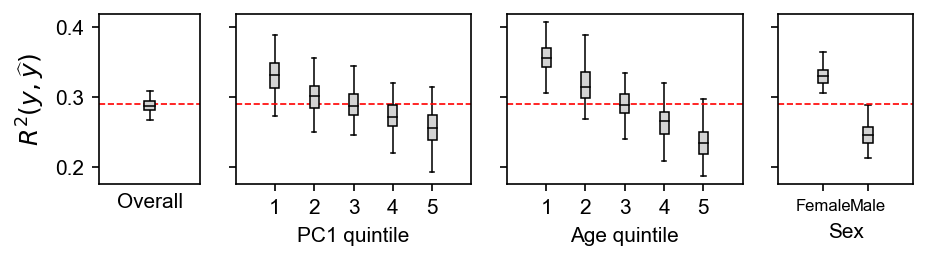

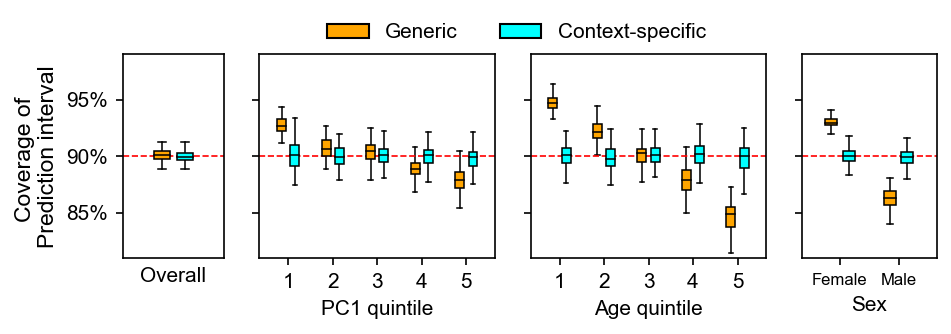

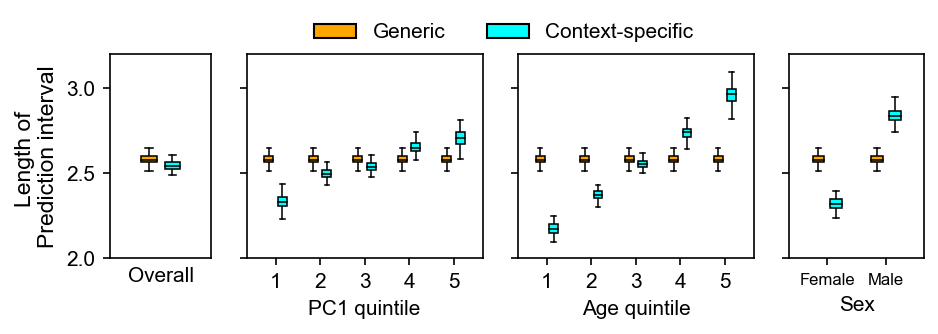

In [3]:
name = "constant_slope.noslope"

df_stats = pd.read_csv(f"cache/{name}.stats.tsv", sep="\t").rename(
    columns={"adjust": "method"}
)
df_stats["group"] = df_stats["col"].apply(lambda x: x.split("_")[0])
df_stats["group"] = df_stats["group"].replace(
    {"marginal": "Overall", "SEX": "Sex", "AGE": "Age"}
)
df_stats["subgroup"] = df_stats["col"].apply(
    lambda x: x.rsplit("_", 1)[1] if "_" in x else ""
)

df_tmp = df_stats.query("n == 5000")
df_tmp = df_tmp[df_tmp.method.isin(["none", "all"])]
df_tmp["method"] = df_tmp["method"].apply(
    lambda x: {"none": "Generic", "all": "Context-specific"}[x]
)

# plot
fig_r2, axes_r2 = calpgs.plot_group_r2(
    df=df_tmp[df_tmp["method"] == "Generic"],
    groups=["Overall", "PC1", "Age", "Sex"],
)
for ax in axes_r2:
    ax.axhline(y=0.29, color="red", lw=0.8, ls="--")

fig_coverage, axes_coverage, fig_length, axes_length = calpgs.plot_group_predint(
    df=df_tmp,
    groups=["Overall", "PC1", "Age", "Sex"],
    methods=["Generic", "Context-specific"],
    method_colors={"Context-specific": "cyan", "Generic": "Orange"},
)
for ax in axes_coverage:
    ax.set_ylim(0.81, 0.99)
    ax.axhline(y=0.9, color="red", lw=0.8, ls="--")

# adjust xticklabels
for axes in [axes_r2, axes_coverage, axes_length]:
    fix_xaxis(axes)

for ax in axes_length:
    ax.set_ylim(2, 3.2)

fig_r2.savefig("results/main_r2.pdf", bbox_inches="tight")
fig_coverage.savefig("results/main_coverage.pdf", bbox_inches="tight")
fig_length.savefig("results/main_length.pdf", bbox_inches="tight")

# Results for other sample sizes

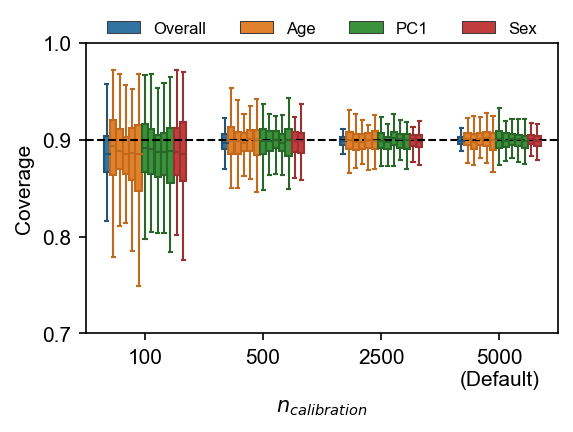

In [4]:
# color palette
palette = dict()
for col in df_stats["col"].unique():
    if col == "marginal":
        palette[col] = "C0"
    elif col.startswith("AGE"):
        palette[col] = "C1"
    elif col.startswith("PC1"):
        palette[col] = "C2"
    elif col.startswith("SEX"):
        palette[col] = "C3"
    else:
        assert False

df_plot = df_stats[df_stats["method"] == "all"].drop(columns=["method"])

fig, ax = plt.subplots(figsize=(4, 3), dpi=150)

sns.boxplot(
    x="n",
    y="coverage",
    hue="col",
    width=0.7,
    linewidth=1.0,
    fliersize=0,
    palette=palette,
    data=df_plot,
    ax=ax,
)

ax.axhline(y=0.9, color="black", lw=1.0, ls="--")
ax.set_xlabel("$n_{calibration}$")
ax.set_ylabel("Coverage")
labels = [lab.get_text() for lab in ax.get_xticklabels()]
labels[-1] = labels[-1] + "\n(Default)"
ax.set_xticklabels(labels)
lighten_boxplot(ax)
handles, labels = ax.get_legend_handles_labels()

handles = [
    h
    for h, lab in zip(handles, labels)
    if lab in ["marginal", "AGE_q_0", "PC1_q_0", "SEX_q_0"]
]

ax.legend(
    handles=handles,
    labels=[
        "Overall",
        "Age",
        "PC1",
        "Sex",
    ],
    title=None,
    ncol=4,
    loc="center",
    bbox_to_anchor=(0.5, 1.05),
    fontsize=8,
    frameon=False,
)
ax.set_ylim(0.7, 1.0)
plt.tight_layout()

# plt.savefig(f"results/simulation_vary_n.pdf", bbox_inches="tight")

# Unmeasured covariates

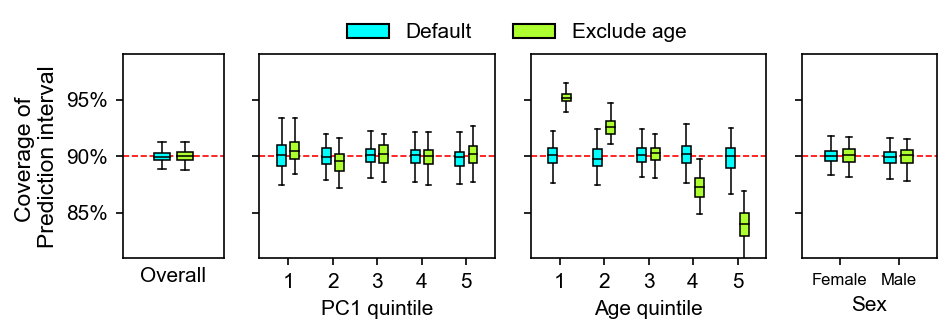

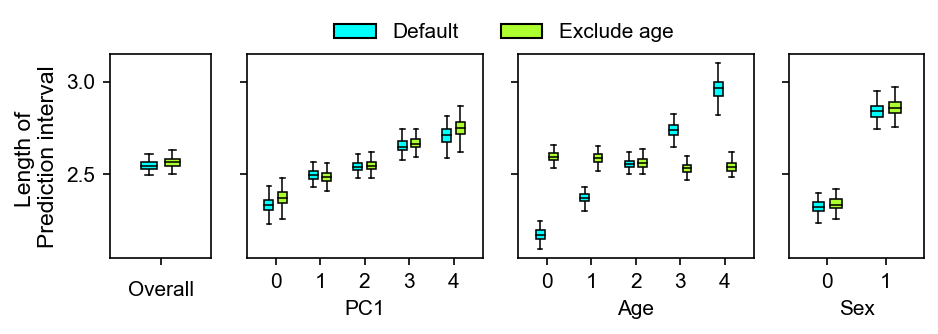

In [5]:
df_tmp = df_stats.query("n == 5000")
df_tmp = df_tmp[df_tmp.method.isin(["all", "except-age"])]
df_tmp["method"] = df_tmp["method"].apply(
    lambda x: {"all": "Default", "except-age": "Exclude age"}[x]
)
fig_coverage, axes_coverage, fig_length, axes_length = calpgs.plot_group_predint(
    df=df_tmp,
    groups=["Overall", "PC1", "Age", "Sex"],
    methods=["Default", "Exclude age"],
    method_colors={"Exclude age": "greenyellow", "Default": "cyan"},
)
for ax in axes_coverage:
    ax.set_ylim(0.81, 0.99)
    ax.axhline(y=0.9, color="red", lw=0.8, ls="--")
fix_xaxis(axes_coverage)

plt.savefig(f"results/simulation_unmeasured_cov.pdf", bbox_inches="tight")

# More dummy covariates

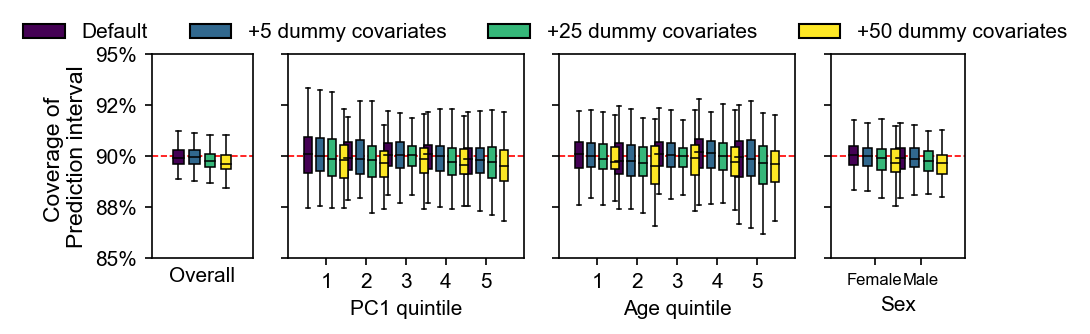

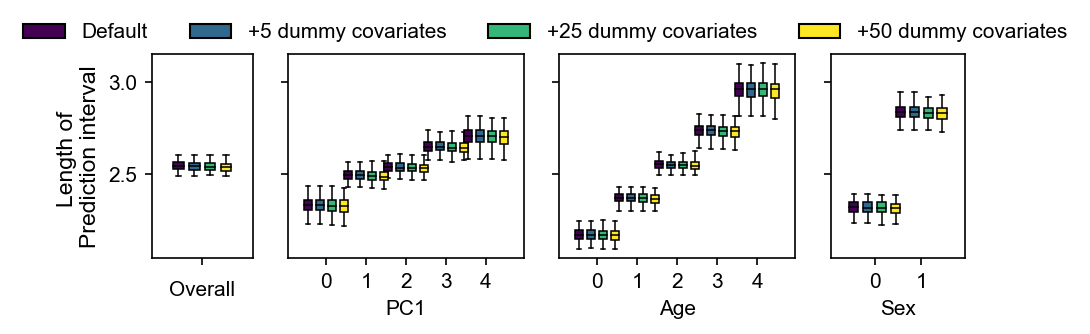

In [6]:
dict_labels = {
    "all": "Default",
    "dummy5": "+5 dummy covariates",
    "dummy25": "+25 dummy covariates",
    "dummy50": "+50 dummy covariates",
}
df_tmp = df_stats.query("n == 5000")
df_tmp = df_tmp[df_tmp.method.isin(dict_labels.keys())]

dict_colors = {
    dict_labels[method]: plt.get_cmap("viridis", 4).colors[i]
    for i, method in enumerate(dict_labels)
}

df_tmp["method"] = df_tmp["method"].apply(lambda x: dict_labels[x])
fig_coverage, axes_coverage, fig_length, axes_length = calpgs.plot_group_predint(
    df=df_tmp,
    groups=["Overall", "PC1", "Age", "Sex"],
    methods=dict_labels.values(),
    method_colors=dict_colors,
)
for ax in axes_coverage:
    ax.set_ylim(0.85, 0.95)
    ax.axhline(y=0.9, color="red", lw=0.8, ls="--")
fix_xaxis(axes_coverage)

# plt.savefig(f"results/simulation_unmeasured_cov.pdf", bbox_inches="tight")